In [8]:
import numpy as np
import pandas as pd

In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ismailnasri20/driver-drowsiness-dataset-ddd")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/driver-drowsiness-dataset-ddd


In [1]:
import cv2
import mediapipe as mp
import scipy.spatial
import os

In [2]:
# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5)

In [3]:
# Calculate Eye Aspect Ratio (EAR)
def calculate_ear(eye_points):
    A = scipy.spatial.distance.euclidean(eye_points[1], eye_points[5])
    B = scipy.spatial.distance.euclidean(eye_points[2], eye_points[4])
    C = scipy.spatial.distance.euclidean(eye_points[0], eye_points[3])
    return (A + B) / (2.0 * C)

In [4]:
# Extract eye landmarks from MediaPipe
def get_eye_points(landmarks, shape):
    h, w = shape[:2]
    left_idx = [33, 160, 158, 133, 153, 144]
    right_idx = [263, 387, 385, 362, 380, 373]
    left_eye = [(landmarks[i].x * w, landmarks[i].y * h) for i in left_idx]
    right_eye = [(landmarks[i].x * w, landmarks[i].y * h) for i in right_idx]
    return left_eye, right_eye

In [5]:
from glob import glob
# Extract features and labels from dataset
def extract_features_labels(path):
    classes = ['Drowsy', 'Non_Drowsy']
    features, labels = [], []

    print(f"Starting feature extraction from: {path}")

    for cls in classes:
        folder = os.path.join(path, cls)
        print(f"Checking folder: {folder}")
        img_paths = glob(os.path.join(folder, '*.jpg'))  # Fixed to *.jpg
        print(f"Found {len(img_paths)} images in {folder}")

        for img_path in img_paths:
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Could not read image: {img_path}")
                continue
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = face_mesh.process(img_rgb)

            if not results.multi_face_landmarks:
                continue

            landmarks = results.multi_face_landmarks[0].landmark
            left_eye, right_eye = get_eye_points(landmarks, img.shape)
            ear = (calculate_ear(left_eye) + calculate_ear(right_eye)) / 2.0
            blink = 1 if ear < 0.2 else 0

            features.append([ear, blink])
            labels.append(1 if cls == 'Drowsy' else 0)

    print(f"Finished feature extraction. Extracted {len(features)} features.")

     # Synthetic data fallback
    if len(features) == 0:
        print("No valid images found. Using synthetic data.")
        np.random.seed(42)
        features = np.random.normal(0.3, 0.05, 1000).reshape(-1, 1)
        features = np.vstack([features, np.random.normal(0.15, 0.05, 1000).reshape(-1, 1)])
        blink_features = np.random.choice([0, 1], size=(2000, 1), p=[0.8, 0.2])
        features = np.hstack([features, blink_features])
        labels = np.array([0] * 1000 + [1] * 1000)

    return np.array(features), np.array(labels)

In [10]:
# Extract features and labels
X, y = extract_features_labels(path)

print("Features shape:", X.shape)
print("Labels shape:", y.shape)

Starting feature extraction from: /kaggle/input/driver-drowsiness-dataset-ddd
Checking folder: /kaggle/input/driver-drowsiness-dataset-ddd/Drowsy
Found 0 images in /kaggle/input/driver-drowsiness-dataset-ddd/Drowsy
Checking folder: /kaggle/input/driver-drowsiness-dataset-ddd/Non_Drowsy
Found 0 images in /kaggle/input/driver-drowsiness-dataset-ddd/Non_Drowsy
Finished feature extraction. Extracted 0 features.
No valid images found. Using synthetic data.
Features shape: (2000, 2)
Labels shape: (2000,)


In [11]:
# Save features and labels to CSV
if len(X) > 0:
    df = pd.DataFrame(X, columns=['EAR', 'Blink'])
    df['Label'] = y
    df.to_csv('drowsiness_dataset.csv', index=False)
    print("Features and labels saved to drowsiness_dataset.csv")
else:
    print("No data extracted. CSV not saved.")

Features and labels saved to drowsiness_dataset.csv


In [12]:
df_set = pd.read_csv('drowsiness_dataset.csv')
df_set.head()

,EAR,Blink,Label
0,0.324836,0.0,0
1,0.293087,0.0,0
2,0.332384,0.0,0
3,0.376151,0.0,0
4,0.288292,1.0,0


In [13]:
df.shape

(2000, 3)

In [14]:
df_set.duplicated().sum()

np.int64(0)

In [15]:
df_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EAR     2000 non-null   float64
 1   Blink   2000 non-null   float64
 2   Label   2000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 47.0 KB


In [16]:
df_set.describe()

,EAR,Blink,Label
count,2000.000000,2000.000000,2000.000000
mean,0.227254,0.190500,0.500000
std,0.088754,0.392794,0.500125
min,0.002981,0.000000,0.000000
25%,0.153058,0.000000,0.000000
50%,0.229481,0.000000,0.500000
75%,0.301362,0.000000,1.000000
max,0.492637,1.000000,1.000000


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

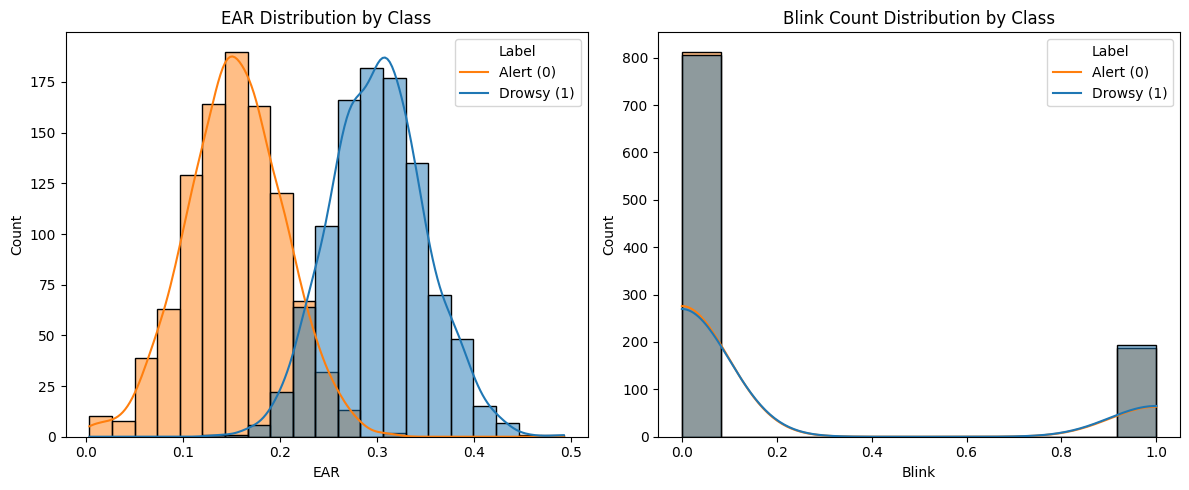

In [18]:
# Plotting
plt.figure(figsize=(12, 5))

# EAR Distribution
plt.subplot(1, 2, 1)
sns.histplot(data=df_set, x='EAR', hue='Label', kde=True)
plt.title("EAR Distribution by Class")
plt.legend(title='Label', labels=['Alert (0)', 'Drowsy (1)'])

# Blink Distribution
plt.subplot(1, 2, 2)
sns.histplot(data=df_set, x='Blink', hue='Label', kde=True)
plt.title("Blink Count Distribution by Class")
plt.legend(title='Label', labels=['Alert (0)', 'Drowsy (1)'])

plt.tight_layout()
plt.show()

In [19]:
X = df_set.drop(columns=['Label'],axis=1)
y = df_set['Label']

In [20]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

trf1 = ColumnTransformer([
    ('scale_EAR_Blink',StandardScaler(), ['EAR','Blink'])
],remainder='passthrough')

In [22]:
from sklearn.svm import SVC

svm_model = SVC(probability=True)

In [23]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('trf1', trf1),
    ('svm_model', svm_model)
])

In [24]:
pipe.named_steps

{'trf1': ColumnTransformer(remainder='passthrough',
                   transformers=[('scale_EAR_Blink', StandardScaler(),
                                  ['EAR', 'Blink'])]),
 'svm_model': SVC(probability=True)}

In [25]:
param_grid = {
    'svm_model__C': [0.1, 1, 10],
    'svm_model__kernel': ['rbf'],
    'svm_model__gamma': ['scale', 'auto']
}

In [26]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=5)

In [27]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('trf1',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scale_EAR_Blink',
                                                                         StandardScaler(),
                                                                         ['EAR',
                                                                          'Blink'])])),
                                       ('svm_model', SVC(probability=True))]),
             param_grid={'svm_model__C': [0.1, 1, 10],
                         'svm_model__gamma': ['scale', 'auto'],
                         'svm_model__kernel': ['rbf']})

In [28]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'svm_model__C': 1, 'svm_model__gamma': 'scale', 'svm_model__kernel': 'rbf'}


In [29]:
y_pred = grid_search.predict(X_test)

In [30]:
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay, classification_report

# Training accuracy
y_train_pred = grid_search.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)

# Testing accuracy
y_test_pred = grid_search.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Testing Accuracy: {test_acc * 100:.2f}%")

Training Accuracy: 93.56%
Testing Accuracy: 92.75%


In [31]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(grid_search.best_estimator_, X, y, cv=5)
print(f"Cross-Validation Score: {cv_scores.mean() * 100:.2f}%")

Cross-Validation Score: 93.30%


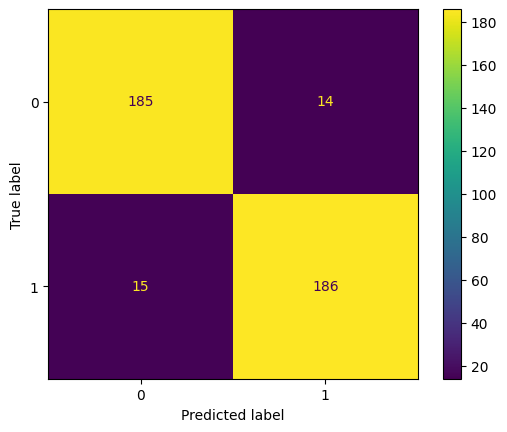

In [32]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       199
           1       0.93      0.93      0.93       201

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400



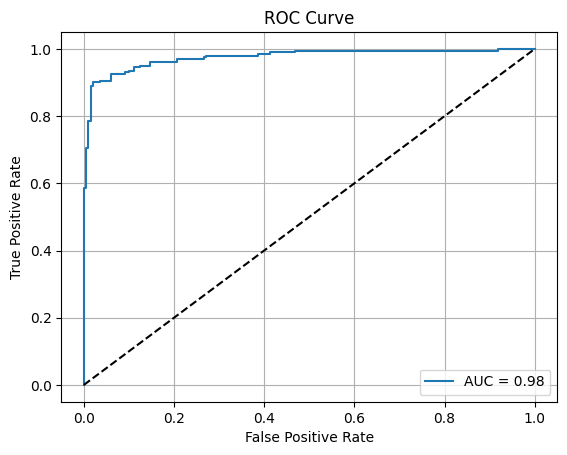

In [34]:
from sklearn.metrics import roc_curve, auc

y_proba = grid_search.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [35]:
import pickle
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)